In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import numpy as np
import my_functions as my
import gsw
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import pandas as pd
import glidertools as gt
from sklearn.linear_model import LinearRegression
import math
import scipy

import my_plot_params

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=3)

yearsFmt = mdates.DateFormatter("%d/%m")

mnthFmt = mdates.DateFormatter("%B")

lightblue = '#5499c7'
blue      = '#21618c'
orange    = '#f39c12'
green     = '#27ae60'
red       = '#cb4335'

/Users/marcel/opt/anaconda3/envs/duplessis2021_JGR/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
# note these are the 1D time series
dat_saz = xr.open_dataset('../data/dat_saz_1D.nc')
dat_pfz = xr.open_dataset('../data/dat_pfz_1D.nc')
dat_miz = xr.open_dataset('../data/dat_miz_1D.nc')

# note these are the 6H time series
dat_saz_6H = xr.open_dataset('../data/dat_saz_interp_fig6.nc')
dat_pfz_6H = xr.open_dataset('../data/dat_pfz_interp_fig6.nc')
dat_miz_6H = xr.open_dataset('../data/dat_miz_interp_fig6.nc')

#### Mean buoyancy of the mixed layer

In [3]:
# get the mean buoyancy within the mixed layer
for dat in [dat_saz, dat_pfz, dat_miz]:

    xb=[]
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        xb += dat.buoyancy.sel(depth=slice(5, m-5)).mean(dim='depth').values[i],
    
    dat['ml_b'] = (('time'), xb)

Determine the lateral buoyancy bouyancy gradient from the interpolated values of buoyancy to a common grid. The grid used here is 2 km. 

In [4]:
sites = ['saz', 'pfz', 'miz']

for i, dat in enumerate([dat_saz, dat_pfz, dat_miz]):
    
    if i==0:
        dat_raw=dat_saz_6H
    if i==1:
        dat_raw=dat_pfz_6H
    if i==2:
        dat_raw=dat_miz_6H
        
    dat_raw['buoyancy'] = -9.81*(dat_raw['density']-1025)/1025
        
    xb=[]
    xt=[]
    xs=[]
    
    for c, m in enumerate(np.round(dat_raw['mld_03'].astype(int))):
        
        xb += dat_raw.buoyancy.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],        
        xt += dat_raw.temp.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],
        xs += dat_raw.salt.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],
    
    dat_raw['ml_s'] = (('time'), xs)
    dat_raw['ml_t'] = (('time'), xt)
    dat_raw['ml_b'] = (('time'), xb)
    
    for c, val in enumerate(dat_raw.ml_b):
            
        if val<-0.027:
            dat_raw['ml_b'][c] = dat_raw['ml_b'][c-1] 
        
    # determin the along-track distance 
    d = gsw.distance(dat_raw.lon.values, dat_raw.lat.values)
    d_sum = np.append(0, np.cumsum(d))
    
    # make a new grid from cumulative sum of the distances
    new_grid = np.arange(0, d_sum[-1], 6000)
    
    t = date2num(dat_raw.time.values)
    
    # interpolate the mixed layer buoyancy and depth to the new grid
    ml_b_6km = scipy.interpolate.griddata(d_sum, dat_raw['ml_b'].values,   new_grid)
    mld_6km  = scipy.interpolate.griddata(d_sum, dat_raw['mld_03'].values, new_grid)
    time_6km = scipy.interpolate.griddata(d_sum, t,                        new_grid)
    
    # find the buoyancy gradients
    ml_bx_6km = np.diff(ml_b_6km)/6000
    
    # Submesoscale MLI equivalent heat flux
    
    #set the parameters for the equivalent heat flux equation
    
    c     = 0.06         # emperically defined coefficient
    bx    = ml_bx_6km    # buoyancy gradient
    H     = mld_6km[1:]  # mixed layer depth
    f     = gsw.f(dat_raw.lat).mean().values # coriolis freq
    Cp    = 3850         # specific heat capacity
    rho0  = 1027         # density
    alpha = gsw.alpha(dat_raw.ml_s, dat_raw.ml_t, 0).mean().values # thermal expansion coeff
    g     = 9.81         # gravitational acceleration
    
    # determine the MLI flux
    
    mli = c * ( (bx**2 * H**2)/np.abs(f) ) * ( (Cp*rho0)/(alpha*g) )
    
    dat_raw['mli'] = (('time'), scipy.interpolate.griddata(time_6km[:-1], mli, t))
    
    ###################
    
    # convert the tendency units of C/s and psu/s to W m-2
    
    hm     = dat['mld_03'] # mixed layer depth
    beta   = -gsw.beta(dat.ml_s_smooth, dat.ml_t_smooth, 0).mean() # haline contraction coeff
    alpha  = gsw.alpha(dat.ml_s_smooth, dat.ml_t_smooth, 0).mean() # haline contraction coeff

    dat['hf_wm2']   = dat['dT_hf']       * (rho0*Cp*hm) # heat flux
    dat['en_t_wm2'] = dat['ent_dT']      * (rho0*Cp*hm) # entrainment
    dat['ek_t_wm2'] = dat['ek_trans_dT'] * (rho0*Cp*hm) # ekman adv
    
    dat['ff_wm2']   = dat['dS_ff']       * (rho0*Cp*hm*(beta/alpha)) # freshwater flux
    dat['ek_s_wm2'] = dat['ek_trans_dS'] * (rho0*Cp*hm*(beta/alpha)) # entrainment
    dat['en_s_wm2'] = dat['ent_dS']      * (rho0*Cp*hm*(beta/alpha)) # ekman adv
    
    dat['mli_wm2']  = dat_raw['mli'].interp_like(dat)

#### Plot the pie chars

('Heat Flux', 'Freshwater Flux', 'Entrainment', 'Ek Adv', 'MLI')
[0.463725429247139, 0.08064716362467986, 0.22418922492178223, 0.22563984909337995, 0.005798333113019026]
('Heat Flux', 'Freshwater Flux', 'Entrainment', 'Ek Adv', 'MLI')
[0.594627809842855, 0.2234906529015366, 0.024737341127401297, 0.13940401198928626, 0.017740184138920694]
('Heat Flux', 'Freshwater Flux', 'Entrainment', 'Ek Adv', 'MLI')
[0.3573651207623609, 0.15885919143069785, 0.45321859057510366, 0.027823837285301276, 0.0027332599465362387]


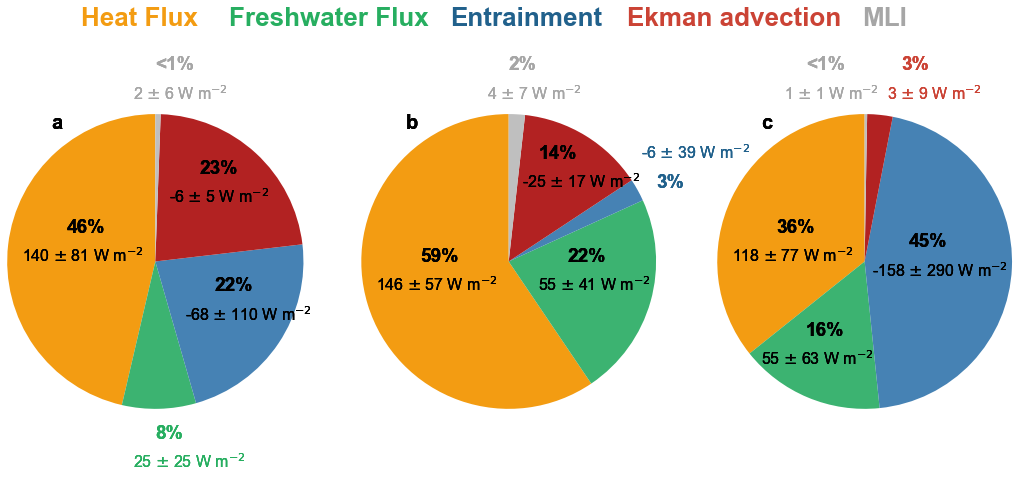

In [90]:
fig, ax = plt.subplots(1, 3, figsize=[18, 6], sharey=True)

for i, dat in enumerate([dat_saz, dat_pfz, dat_miz]):
    
    # now plot the pie chart
    
    labels = 'Heat Flux', 'Freshwater Flux', 'Entrainment', 'Ek Adv', 'MLI'
    clrs   = orange, 'mediumseagreen', 'steelblue', 'firebrick', '0.75'
    
    hf   = np.nanmean(np.abs(dat['hf_wm2']))
    ff   = np.nanmean(np.abs(dat['ff_wm2']))
    
    en = np.nanmean(np.abs(dat['en_t_wm2']) + np.abs(dat['en_s_wm2']))
    ek = np.nanmean(np.abs(dat['ek_t_wm2']) + np.abs(dat['ek_s_wm2']))
    
    sm   = np.nanmean(np.abs(dat['mli_wm2']))
    
    total = hf+ff+en+ek+sm   
    
    sizes = [hf/total, ff/total, en/total, ek/total, sm/total]
        
    ax[i].pie(sizes, 
#            labels=labels, 
#            autopct='%1.1f%%', 
           colors=clrs,
           startangle=90)
    
    print(labels)
    
    print(sizes)
    
    ax[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    props = dict(fontsize=26, fontweight='bold')
    if i==1:
        
        ax[i].text(-2.9,1.6,'Heat Flux', c=orange, **props)
        ax[i].text(-1.9,1.6,'Freshwater Flux', c=green, **props)
        ax[i].text(-0.4,1.6,'Entrainment', c=blue, **props)
        ax[i].text(0.8, 1.6,'Ekman advection', c=red, **props)
        ax[i].text(2.4, 1.6,'MLI', c='0.65', **props)
    
#     ax.legend(ncol=6, bbox_to_anchor=(0, 1))

    props_per = dict(fontsize=19,fontweight='bold')
    props_wm2 = dict(fontsize=16)

    ### SAZ ###
    
    #heat flux 
    ax[0].text(-0.6, 0.2, '46%', **props_per)
    ax[0].text(-0.9, 0, '140 $\pm$ 81 W m$^{-2}$', **props_wm2)
  
    #MLI
    ax[0].text(0, 1.3, '<1%',                        **props_per, c='0.65')
    ax[0].text(-0.15, 1.1, '2 $\pm$ 6 W m$^{-2}$', **props_wm2, c='0.65')
  
    #Ekman advection
    ax[0].text(0.3, 0.6, '23%',                       **props_per, c='k')
    ax[0].text(0.09, 0.4, '-6 $\pm$ 5 W m$^{-2}$', **props_wm2, c='k')
    
    #entrainment 
    ax[0].text(0.4, -0.2, '22%',                       **props_per, c='k')
    ax[0].text(0.2, -0.4, '-68 $\pm$ 110 W m$^{-2}$', **props_wm2, c='k')
    
    #entrainment 
    ax[0].text(0, -1.2, '8%',                         **props_per, c=green)
    ax[0].text(-0.15, -1.4, '25 $\pm$ 25 W m$^{-2}$', **props_wm2, c=green)
    
    ### PFZ ###
    
    #heat flux 
    ax[1].text(-0.6, 0, '59%',                       **props_per)
    ax[1].text(-0.9, -0.2, '146 $\pm$ 57 W m$^{-2}$', **props_wm2)
  
    #MLI
    ax[1].text(0, 1.3, '2%',                     **props_per, c='0.65')
    ax[1].text(-0.15, 1.1, '4 $\pm$ 7 W m$^{-2}$', **props_wm2, c='0.65')
  
    #Ekman advection
    ax[1].text(0.2, 0.7, '14%',                      **props_per, c='k')
    ax[1].text(0.09, 0.5, '-25 $\pm$ 17 W m$^{-2}$', **props_wm2, c='k')
    
    #entrainment 
    ax[1].text(1.0, 0.5, '3%',                   **props_per, c=blue)
    ax[1].text(0.9, 0.7, '-6 $\pm$ 39 W m$^{-2}$', **props_wm2, c=blue)
    
    #freshwater flux 
    ax[1].text(0.4, 0, '22%',                    **props_per, c='k')
    ax[1].text(0.2, -0.2, '55 $\pm$ 41 W m$^{-2}$', **props_wm2, c='k')
    
    
    ### MIZ ###
    
    #heat flux 
    ax[2].text(-0.6, 0.2, '36%',                       **props_per)
    ax[2].text(-0.9, 0, '118 $\pm$ 77 W m$^{-2}$', **props_wm2)
  
    #MLI
    ax[2].text(-0.4, 1.3, '<1%',                     **props_per, c='0.65')
    ax[2].text(-0.55, 1.1, '1 $\pm$ 1 W m$^{-2}$', **props_wm2, c='0.65')
  
    #Ekman advection
    ax[2].text(0.25, 1.3, '3%',                  **props_per, c=red)
    ax[2].text(0.15, 1.1, '3 $\pm$ 9 W m$^{-2}$', **props_wm2, c=red)
    
    #entrainment 
    ax[2].text(0.3, 0.1, '45%',                   **props_per,     c='k')
    ax[2].text(0.05, -0.1, '-158 $\pm$ 290 W m$^{-2}$', **props_wm2, c='k')
    
    #freshwater flux 
    ax[2].text(-0.4, -0.5, '16%',                    **props_per, c='k')
    ax[2].text(-0.7, -0.7, '55 $\pm$ 63 W m$^{-2}$', **props_wm2, c='k')
    
    ax[0].text(-0.7, 0.9, 'a', fontweight='bold', fontsize=20)
    ax[1].text(-0.7, 0.9, 'b', fontweight='bold', fontsize=20)
    ax[2].text(-0.7, 0.9, 'c', fontweight='bold', fontsize=20)
    
    plt.savefig('../figs_submission2/fig10.png', dpi=300, bbox_inches='tight')

In [7]:
for i, dat in enumerate([dat_saz, dat_pfz, dat_miz]):
    
    print('-----')
    
    print('heat flux: ' + str(np.round(np.nanmean(dat['hf_wm2'] .values))) + ' std ' + str(np.round(np.nanstd(dat['hf_wm2'] .values))))
    print('fresh flx: ' + str(np.round(np.nanmean(dat['ff_wm2'] .values))) + ' std ' + str(np.round(np.nanstd(dat['ff_wm2'] .values))))
    print('sms mli  : ' + str(np.round(np.nanmean(dat['mli_wm2'].values))) + ' std ' + str(np.round(np.nanstd(dat['mli_wm2'].values))))
    
    en = dat['en_t_wm2'] + dat['en_s_wm2'] # substract the salinity equiv. W m-2 from the temperature as neg salinity means freshening
    ek = dat['ek_t_wm2'] + dat['ek_s_wm2'] # substract the salinity equiv. W m-2 from the temperature as neg salinity means freshening
    
    print('entrainmt: ' + str(np.round(np.nanmean(en.values))) + ' std ' + str(np.round(np.nanstd(en.values))))
    print('ekmanadvn: ' + str(np.round(np.nanmean(ek.values))) + ' std ' + str(np.round(np.nanstd(ek.values))))

-----
heat flux: 140.0 std 81.0
fresh flx: 25.0 std 26.0
sms mli  : 2.0 std 4.0
entrainmt: -68.0 std 110.0
ekmanadvn: -6.0 std 5.0
-----
heat flux: 146.0 std 57.0
fresh flx: 55.0 std 41.0
sms mli  : 4.0 std 7.0
entrainmt: -6.0 std 39.0
ekmanadvn: -25.0 std 17.0
-----
heat flux: 118.0 std 77.0
fresh flx: 55.0 std 63.0
sms mli  : 1.0 std 1.0
entrainmt: -158.0 std 290.0
ekmanadvn: 3.0 std 9.0
